In [204]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import time
import progressbar
import importlib
import random
# torch.manual_seed(1)    # reproducible
plt.style.use('default')
%matplotlib inline

import pdb

import Models_MNIST as mds

# Hyper Parameters
EPOCH = 300
BATCH_SIZE = 256
DOWNLOAD_MNIST = False
m1 = 64
m2 = 128
m3 = 512
cudaopt = True

EPS = 1e-4

# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='../data',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=True,                        # download it if you don't have it
)

# LIMITING TRAINING DATA
Ntrain = int(2e3)
train_set = np.random.permutation(60000)[0:Ntrain]
train_data.train_data = train_data.train_data[torch.LongTensor(train_set),:,:]
train_data.train_labels = train_data.train_labels[torch.LongTensor(train_set)]

test_data = torchvision.datasets.MNIST(
    root='../data',
    train=False,                                     # this is testing data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=True,                        # download it if you don't have it
)

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

### Model Baseline

In [ ]:
Loss_test_0 = np.zeros((EPOCH,))
Acc_test_0 = np.zeros((EPOCH,))
Acc_train_0 = np.zeros((EPOCH,))

print('\n\t\t\t\t\tTraining Baseline\n')

T = 2
RHO = 0

model_0 = mds.ML_ISTA_NET(m1,m2,m3)
if cudaopt:
    model_0.cuda()

optimizer = torch.optim.Adam(model_0.parameters(), lr = 0.0001, eps = EPS)
bar = progressbar.ProgressBar()

for epoch in range(EPOCH):

    bar.update((epoch+1)/EPOCH*100)
    # train 1 epoch
    model_0.train()
    train_correct = 0
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        encoded, scores = model_0(b_x,T,RHO)
        
        train_pred = scores.data.max(1, keepdim=True)[1]
        train_correct += train_pred.eq(b_y.data.view_as(train_pred)).long().cpu().sum()
        
        loss = F.nll_loss(scores, b_y)      # negative log likelyhood
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
    
    Acc_train_0[epoch] =  100 * float(train_correct) /float(len(train_loader.dataset))
    
    # testing
    model_0.eval()
    correct = 0
    test_loss = 0
    for step, (x, y) in enumerate(test_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        gamma, scores = model_0(b_x,T,RHO)
        test_loss += F.nll_loss(scores, b_y, size_average=False).data[0]
        pred = scores.data.max(1, keepdim=True)[1]
        correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    Loss_test_0[epoch] = test_loss
    Acc_test_0[epoch] =  100 * float(correct) /float(len(test_loader.dataset))
    
# torch.save(model_0.state_dict(), 'cnn_model.pt')

100% (100 of 100) |#######################| Elapsed Time: 0:05:34 Time: 0:05:34
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


					Training Baseline



C:\Users\Jere\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
 11% (11.333333333333332 of 100) |        | Elapsed Time: 0:01:08 ETA:  0:09:25

### J-ISTA

In [ ]:
# test
W1 = nn.Parameter(torch.randn(m1,1,6,6), requires_grad=True)
strd1 = 2;
W2 = nn.Parameter(torch.randn(m2,m1,6,6), requires_grad=True)
strd2 = 2;
W3 = nn.Parameter(torch.randn(m3,m2,4,4), requires_grad=True)
strd3 = 1;
        # Biases / Thresholds
b1 = nn.Parameter(torch.zeros(1,m1,1,1), requires_grad=True)
b2 = nn.Parameter(torch.zeros(1,m2,1,1), requires_grad=True)
b3 = nn.Parameter(torch.zeros(1,m3,1,1), requires_grad=True)
       
        # Classifier
Wclass = nn.Linear(m3, 10)
       
        # Initialization
W1.data = 0.01 * W1.data
W2.data = 0.01 * W2.data
W3.data = 0.01 * W3.data

In [ ]:
b_x = Variable(x)   # batch x, shape (batch, 28*28)
b_y = Variable(y)               # batch label
if cudaopt:
    b_y, b_x = b_y.cuda(), b_x.cuda()


gamma1 = F.relu(F.conv2d(x,W1, stride = strd1) + b1)       # first estimation
gamma2 = F.relu(F.conv2d(gamma1,W2, stride = strd2) + b2) 
# gamma_3 = F.relu(F.conv2d(gamma2,W3, stride = strd3) + b3) 
X = F.conv2d(gamma2,W3, stride = strd3)
gamma3 = torch.zeros(X.shape)
for i in range(10):
    if torch.sum(b_y==i)>0:
        X_i = X[b_y==i,:,:,:]
        x_i = torch.sqrt(torch.sum(X_i**2,dim=0)) # computing norm of rows
        a_i = F.relu(x_i + b3) 
        X_i = X_i/x_i
        X_i = X_i * a_i
        gamma3[b_y==i,:,:,:] = X_i


In [224]:
importlib.reload(mds)

Loss_test_jista_r = np.zeros((EPOCH,))
Acc_test_jista_r = np.zeros((EPOCH,))
Acc_train_jista_r = np.zeros((EPOCH,))

print('\n\t\t\t\t\tTraining ML-JISTA \n')

model_jnn = mds.ML_JISTA_NET_J(m1,m2,m3)
if cudaopt:
    model_jnn.cuda()

optimizer = torch.optim.Adam(model_jnn.parameters(), lr = 0.0001, eps = EPS)
bar = progressbar.ProgressBar()

for epoch in range(EPOCH):
#     print("Epoch: " + str(int(epoch)))
    bar.update((epoch+1)/EPOCH*100)
    # train 1 epoch
    model_jnn.train()
    
    train_correct = 0
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        encoded, scores = model_jnn.forward_joint(b_x, b_y, T, RHO)
        
        train_pred = scores.data.max(1, keepdim=True)[1]
        train_correct += train_pred.eq(b_y.data.view_as(train_pred)).long().cpu().sum()
        
        loss = F.nll_loss(scores, b_y)      # negative log likelyhood
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
    
    Acc_train_jista_r[epoch] =  100 * float(train_correct) /float(len(train_loader.dataset))    
        
    # testing
    model_jnn.eval()
    correct = 0
    test_loss = 0
    for step, (x, y) in enumerate(test_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        gamma, scores = model_jnn.forward(b_x,T,RHO)
        test_loss += F.nll_loss(scores, b_y, size_average=False).data[0]
        pred = scores.data.max(1, keepdim=True)[1]
        correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    Loss_test_jista_r[epoch] = test_loss
    Acc_test_jista_r[epoch] =  100 * float(correct) /float(len(test_loader.dataset))
#     print("Performance at epoch " + str(int(epoch)) + ": " + str(Acc_test_ista_r[epoch]))
    
# torch.save(model_jnn.state_dict(), 'mljista_model.pt')

100% (100 of 100) |#######################| Elapsed Time: 0:02:05 Time: 0:02:05
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


					Training ML-JISTA 



C:\Users\Jere\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
 12% (12.0 of 100) |##                    | Elapsed Time: 0:02:23 ETA:  0:17:56

KeyboardInterrupt: 

## Plot accuracies

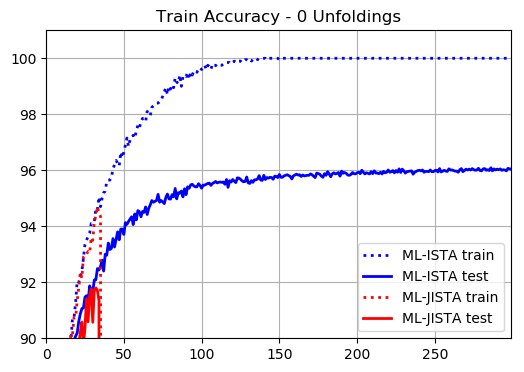

In [235]:
plt.style.use('default')
fig = plt.figure(figsize=(6,4))
plt.plot(Acc_train_0, ':b', linewidth = 2,label='ML-ISTA train')
plt.plot(Acc_test_0,'b',linewidth = 2,label='ML-ISTA test')
# plt.plot(Acc_test_ista_r, linewidth = 2,label = 'ML-ISTA')
plt.plot(Acc_train_jista_r,':r', linewidth = 2,label = 'ML-JISTA train')
plt.plot(Acc_test_jista_r,'r', linewidth = 2,label = 'ML-JISTA test')
# plt.plot(Acc_test_fista_r, linewidth = 2,label = 'ML-FISTA')
plt.grid('on')
plt.title('Train Accuracy - 0 Unfoldings')
plt.legend()
plt.axis([0, EPOCH-1, 90, 101])
plt.show()

## Visualise global filters of baseline

In [ ]:
cols = 10
rows = 10
indices = random.sample(range(m3), cols*rows)

dict1 = model_0.W3
atom1_dim = dict1.shape[3]
print(dict1.shape)

dict2 = F.conv_transpose2d(dict1, model_0.W2, stride=model_0.strd1, dilation=1)
atom2_dim = dict2.shape[3]
print(dict2.shape)

dict3 = F.conv_transpose2d(dict2, model_0.W1, stride=model_0.strd2, dilation=1)
atom3_dim = dict3.shape[3]
print(dict3.shape)

idx = 1
plt.figure(figsize=(10,10))
for j in range(rows):
    for i in range(cols):
        plt.subplot(cols,rows,idx)
        plt.imshow(np.reshape(dict3.cpu().data.numpy()[idx-1], (atom3_dim, atom3_dim)), cmap='gray')
        plt.axis('off')
        idx+=1

plt.show()

## Visualise global filters of JISTA

In [ ]:
cols = 10
rows = 10
indices = random.sample(range(m3), cols*rows)

dict1 = model_jnn.W3
atom1_dim = dict1.shape[3]
print(dict1.shape)

dict2 = F.conv_transpose2d(dict1, model_jnn.W2, stride=model_jnn.strd1, dilation=1)
atom2_dim = dict2.shape[3]
print(dict2.shape)

dict3 = F.conv_transpose2d(dict2, model_jnn.W1, stride=model_jnn.strd2, dilation=1)
atom3_dim = dict3.shape[3]
print(dict3.shape)

idx = 1
plt.figure(figsize=(10,10))
for j in range(rows):
    for i in range(cols):
        plt.subplot(cols,rows,idx)
        plt.imshow(np.reshape(dict3.cpu().data.numpy()[idx-1], (atom3_dim, atom3_dim)), cmap='gray')
        plt.axis('off')
        idx+=1

plt.show()